<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/W3D5_initial_commit/tutorials/W3D5_DeepLearning2/W3D5_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy: Week 3, Day 5, Tutorial 1
# Deep Learning 2: Autoencoders

# Introduction to autoencoders
In this tutorial, you will learn about **Autoencoders**. Autoencoder networks learn low dimensional representations of data through an auxiliary task of compression and decompression. In general, these networks are characterized by an equal number of input and output units and a *bottleneck layer* with fewer units.

![Single hidden layer ANN autoencoder](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/autoencoders/ae-ann-1h.png)

The *encoder* component compresses data from the original high dimensional space into the lower-dimensional *bottleneck layer*. The *decoder* does the opposite by expanding data represented in the *bottleneck layer* back to the original space. Differences between inputs and outputs trigger the backpropagation of loss. Each input samples maps to a coordinate in the bottleneck layer, which spans a lower-dimensional, latent space.

&nbsp; 

Autoencoders are examples of models that automatically build internal representations of the world and use them to predict unseen data.

&nbsp; 
#Tutorial Objectives

In this tutorial, you will:
1. Get acquainted with basic ways to create and visualize low-dimensional representations, i.e. Principan component analysis (PCA) and Non-negative matrix factorization (NMF)
2. Build and train a single hidden layer ANN autoencoder
3. Inspect the representational power of autoencoders with latent spaces of different dimensions

Video available at https://youtube.com/watch?v=Lb2ycpMC7oM


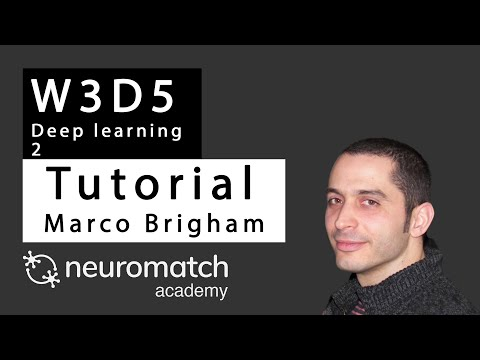

In [1]:
#@title Video: Intro
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="Lb2ycpMC7oM", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

# Setup

In [2]:
# Imports
import numpy as np                 # import numpy
import matplotlib.pyplot as plt    # import matplotlib
from IPython import display        
from IPython.display import YouTubeVideo

import torch
import torchvision
from torch import nn, optim

import sklearn as sk
from sklearn import manifold, decomposition

In [3]:
# @title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.style.use('ggplot')
fig_w, fig_h = (8, 6)
plt.rcParams['figure.figsize'] = (fig_w, fig_h)
plt.rcParams['font.size'] = 14

In [4]:
#@title Helper functions

np.random.seed(0)
def eval_mse(y_pred, y_true):
  """
  Evaluates mean square error (MSE) between y_pred and y_true
  
  Args:
    y_pred (torch.Tensor)
        prediction samples

    v (numpy array of floats)
        ground truth samples
            
  Returns:
    MSE(y_pred, y_true)
  """

  with torch.no_grad():
      criterion = nn.MSELoss()
      loss = criterion(y_pred, y_true)

  return float(loss)


def eval_bce(y_pred, y_true):
  """
  Evaluates binary cross-entropy (BCE) between y_pred and y_true
  
  Args:
    y_pred (torch.Tensor)
        prediction samples

    v (numpy array of floats)
        ground truth samples
            
  Returns:
    BCE(y_pred, y_true)
  """

  with torch.no_grad():
      criterion = nn.BCELoss()
      loss = criterion(y_pred, y_true)

  return float(loss)


def plot_row(images, show_n=10, image_shape=None):
  """
  Plots rows of images from list of iterables (iterables: list, numpy array 
  or torch.Tensor). Also accepts single iterable.
  Randomly selects images in each list element if item count > show_n.
  
  
  Args:
    images (iterable or list of iterables)
        single iterable with images, or list of iterables

    show_n (integer)
        maximum number of images per row

    image_shape (tuple or list)
        original shape of image if vectorized form
            
  Returns:
    Nothing.
  """

  if not isinstance(images, (list, tuple)):
    images = [images]

  for items_idx, items in enumerate(images):

    items = np.array(items)
    if items.ndim==1:
      items = np.expand_dims(items, axis=0)

    if len(items)>show_n:
      selected = np.random.choice(len(items), show_n, replace=False)
      items = items[selected]

    if image_shape is not None:
      items = items.reshape([-1]+list(image_shape))

    fig = plt.figure(figsize=(len(items)*1.5, 2))
    for image_idx, image in enumerate(items):

      plt.subplot(1, len(items), image_idx + 1)
      plt.imshow(image, cmap='gray', vmin=image.min(), vmax=image.max())
      plt.axis('off')

      plt.tight_layout()


def xy_lim(x):
  """
  Return arguments for plt.xlim and plt.ylim calculated from minimum 
  and maximum of x.
  
  
  Args:
    x (list, numpy array or torch.Tensor of floats)
        data to be plotted
            
  Returns:
    Nothing.
  """

  x_min = np.min(x, axis=0)
  x_max = np.max(x, axis=0)

  if x_min[0]==x_max[0]:
    x_max[0]+=1e-15
  if x_min[1]==x_max[1]:
    x_max[1]+=1e-15

  return [x_min[0], x_max[0]], [x_min[1], x_max[1]]
    

def plot_generative(x, decoder_fn, image_shape, n_row=16):
  """
  Plots images reconstructed by decoder_fn from a 2D grid in 
  latent space that is determined by minimum and maximum values in x.    
  
  Args:
    x (list, numpy array or torch.Tensor of floats)
        2D coordinates in latent space

    decoder_fn (integer)
        function returning vectorized images from 2D latent space coordinates

    image_shape (tuple or list)
        original shape of image

    n_row
        number of rows in grid
            
  Returns:
    Nothing.
  """

  xlim, ylim = xy_lim(np.array(x))
  
  dx = (xlim[1]-xlim[0])/n_row
  grid = [np.linspace(ylim[0]+dx/2, ylim[1]-dx/2, n_row),
          np.linspace(xlim[0]+dx/2, xlim[1]-dx/2, n_row)]

  canvas = np.zeros((image_shape[0]*n_row, image_shape[1]*n_row))

  cmap = plt.get_cmap('gray')

  for j, latent_y in enumerate(grid[0][::-1]):
    for i, latent_x in enumerate(grid[1]):

      latent = np.array([latent_x, latent_y], dtype=np.float32)
      with torch.no_grad():
          x_decoded = decoder_fn(torch.from_numpy(latent))
      
      x_decoded = x_decoded.reshape(image_shape)

      canvas[j*image_shape[0]: (j+1)*image_shape[0],
              i*image_shape[1]: (i+1)*image_shape[1]] = x_decoded
  
  plt.imshow(canvas, cmap=cmap, vmin=canvas.min(), vmax=canvas.max())
  plt.axis('off')


def plot_latent(x, y, show_n=500, fontdict=None):
  """
  Plots in 2D latent space locations the digit class of each sample.
  
  Args:
    x (list, numpy array or torch.Tensor of floats)
        2D coordinates in latent space 

    y (list, numpy array or torch.Tensor of floats)
        digit class of each sample

    n_row (integer)
        number of samples

    fontdict (dictionary)
        style option for plt.text
            
  Returns:
    Nothing.
  """

  if fontdict is None:
    fontdict = {'weight': 'bold', 'size': 10}

  cmap = plt.get_cmap('tab10')

  if len(x)>show_n:
    selected = np.random.choice(len(x), show_n, replace=False)
    x = x[selected]
    y = y[selected]

  for my_x, my_y in zip(x, y):
    plt.text(my_x[0], my_x[1], str(int(my_y)),
              color=cmap(int(my_y)/10.),
              fontdict=fontdict,
              alpha=0.8)
      
  xlim, ylim = xy_lim(np.array(x))
  plt.xlim(xlim)
  plt.ylim(ylim)


def plot_latent_generative(x, y, decoder_fn, image_shape, title=None):
  """
  Two horizontal subplots generated with plot_latent and plot_generative. 

  Args:
    x (list, numpy array or torch.Tensor of floats)
        2D coordinates in latent space 

    y (list, numpy array or torch.Tensor of floats)
        digit class of each sample

    decoder_fn (integer)
        function returning vectorized images from 2D latent space coordinates

    image_shape (tuple or list)
        original shape of image

    title (string)
        plot title
            
  Returns:
    Nothing.
  """

  fig = plt.figure(figsize=(12,6))

  if title is not None:
    fig.suptitle(title, y=1.05, fontsize=16)

  ax = fig.add_subplot(121)
  ax.set_title('Latent space map')
  plot_latent(x, y)

  ax = fig.add_subplot(122)
  ax.set_title('Reconstruction grid')    
  plot_generative(x, decoder_fn, image_shape)

  plt.tight_layout()
  plt.show()


def plot_latent_ab(x1, x2, y, selected_idx=None, 
                   title_a='Before', title_b='After', show_n=500, s2=False):
  """
  Two horizontal subplots generated with plot_latent. 

  Args:
    x1 (list, numpy array or torch.Tensor of floats)
        2D coordinates in latent space (left plot)

    x2 (list, numpy array or torch.Tensor of floats)
        digit class of each sample (right plot)

    y (list, numpy array or torch.Tensor of floats)
        digit class of each sample

    selected_idx (list of integers)
        indexes of elements to be plotted

    show_n (integer)
        maximum number of samples in each plot

    s2 (boolean)
        convert 3D coordinates (x, y, z) to spherical coordinates (theta, phi)
            
  Returns:
    Nothing.
  """

  fontdict = {'weight': 'bold', 'size': 12}

  if len(x1)>show_n:

    if selected_idx is None:
      selected_idx = np.random.choice(len(x1), show_n, replace=False)

    x1 = x1[selected_idx]
    x2 = x2[selected_idx]
    y = y[selected_idx]

  data = np.concatenate([x1, x2])

  fig = plt.figure(figsize=(12,6))

  ax = plt.subplot(121)
  ax.set_title(title_a)
  plot_latent(x1, y, fontdict=fontdict)

  ax = plt.subplot(122)
  ax.set_title(title_b)
  plot_latent(x2, y, fontdict=fontdict)

  plt.tight_layout()


def runSGD(net, input_train, input_test, minibatch_fn=None, criterion='bce', 
                n_epochs=10, batch_size=32, verbose=True):
  """
  Trains autoencoder network with stochastic gradient descent with Adam 
  optimizer and loss criterion. Train samples are shuffled, and loss is 
  displayed at the end of each opoch for both MSE and BCE. Plots training loss 
  at each minibatch (maximum of 500 randomly selected values).

  Args:
    net (torch network)
        ANN object (nn.Module)

    input_train (torch.Tensor)
        vectorized input images from train set

    input_test (torch.Tensor)
        vectorized input images from test set

    minibatch_fn (function)
        training steps for mini-batch

    criterion (string)
        train loss: 'bce' or 'mse'

    n_epochs (boolean)
        number of full iterations of training data
        
    batch_size (integer)
        number of element in mini-batches

    verbose (boolean)
        whether to print epoch loss and training loss plot

  Returns:
    Nothing.
  """

  # Initialize loss function
  if criterion=='mse':
    loss_fn = nn.MSELoss()
  elif criterion=='bce':
    loss_fn = nn.BCELoss()
  else:
    print('Please specify either "mse" or "bce" for loss criterion')

  # Initialize SGD optimizer
  optimizer = optim.Adam(net.parameters())

  # Placeholder for loss
  track_loss = []

  print('Epoch', '\t', 'Loss train', '\t', 'Loss test')
  for i in range(n_epochs):

      shuffle_idx = np.random.permutation(len(input_train))
      batches = torch.split(input_train[shuffle_idx], batch_size)
      
      for batch in batches:

        if minibatch_fn is None:
          output_train = model(batch)
          loss = loss_fn(output_train, batch)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

        else:
          loss = minibatch_fn(model, loss_fn, optimizer, batch)

        # Keep track of loss at each epoch
        track_loss += [float(loss)]
      
      loss_epoch = '{}/{}'.format(i+1, n_epochs)
      with torch.no_grad():
        output_train = model(input_train)
        loss_train = loss_fn(output_train, input_train)
        loss_epoch += '\t {:.4f}'.format(loss_train)

        output_test = model(input_test)
        loss_test = loss_fn(output_test, input_test)
        loss_epoch += '\t\t {:.4f}'.format(loss_test)

      if verbose:
        print(loss_epoch)

  # Print loss
  loss_mse = '\nmse\t {:0.4f}'.format(eval_mse(output_train, input_train))
  loss_mse += '\t\t {:0.4f}'.format(eval_mse(output_test, input_test))
  print(loss_mse)

  loss_bce = 'bce\t {:0.4f}'.format(eval_bce(output_train, input_train))
  loss_bce += '\t\t {:0.4f}'.format(eval_bce(output_test, input_test))
  print(loss_bce)

  # Plot loss
  if verbose:
    step = int(np.ceil(len(track_loss)/500))
    plt.figure()
    plt.plot(track_loss[::step], 'C1')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.xlim([0, None])
    plt.ylim([0, None])
    plt.show()

---
## 1. The MNIST dataset
The [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) contains handwritten digits in square images of 28x28 pixels of grayscale levels. There are 60,000 training images and 10,000 testing images from different writers.

Get acquainted with the data by inspecting data type, shape, and visualizing samples with the function `plot_row()`.

**Helper function(s)**

In [5]:
help(plot_row)

Help on function plot_row in module __main__:

plot_row(images, show_n=10, image_shape=None)
    Plots rows of images from list of iterables (iterables: list, numpy array 
    or torch.Tensor). Also accepts single iterable.
    Randomly selects images in each list element if item count > show_n.
    
    
    Args:
      images (iterable or list of iterables)
          single iterable with images, or list of iterables
    
      show_n (integer)
          maximum number of images per row
    
      image_shape (tuple or list)
          original shape of image if vectorized form
              
    Returns:
      Nothing.



### 1.1 Download MNIST dataset
The function `torchvision.datasets.MNIST` downloads the dataset, and we assign train and test sets to (`x_train`, `y_train`) and (`x_test`, `y_test`), respectively.

(`x_train`, `x_test`) contain images and (`y_train`, `y_test`) contain labels from `0` to `9`.

Pixel values are integers between `0` and `255`, and we cast them to floats between `0` and `1`. This range is better for training the autoencoder.

**Hints**

* Please execute the cell(s) below
* What is the type of `x_train`?
* What are the shape and numeric representation of `x_train`?
* Inspect the size and format of train and test data. What is the image shape?

In [6]:
dataset_train = torchvision.datasets.MNIST('../data', train=True, download=True)
dataset_test = torchvision.datasets.MNIST('../data', train=False, download=True)

x_train = dataset_train.data
y_train = dataset_train.targets

x_test = dataset_test.data
y_test = dataset_test.targets

x_train = x_train/255.
x_test = x_test/255.

image_shape = x_train.shape[1:]

test_selected_idx = np.random.choice(len(x_test), 10, replace=False)
train_selected_idx = np.random.choice(len(x_train), 10, replace=False)

print('shape train set:', x_train.shape)
print('shape test set:', x_test.shape)
print('shape image:', image_shape)

shape train set: torch.Size([60000, 28, 28])
shape test set: torch.Size([10000, 28, 28])
shape image: torch.Size([28, 28])


### 1.2 Visualize samples
The variable `image_shape` stores the shape of the images, and the variables `train/test_selected_idx` store `10` random indexes from the train and test data.

We use the function `np.random.choice` to select `10` indexes from `x_train` and `y_train` without replacement

**Hints**
* Please execute the cell(s) below
* Plot samples with the function `plot_row()` a few times to get a visual feel of the data

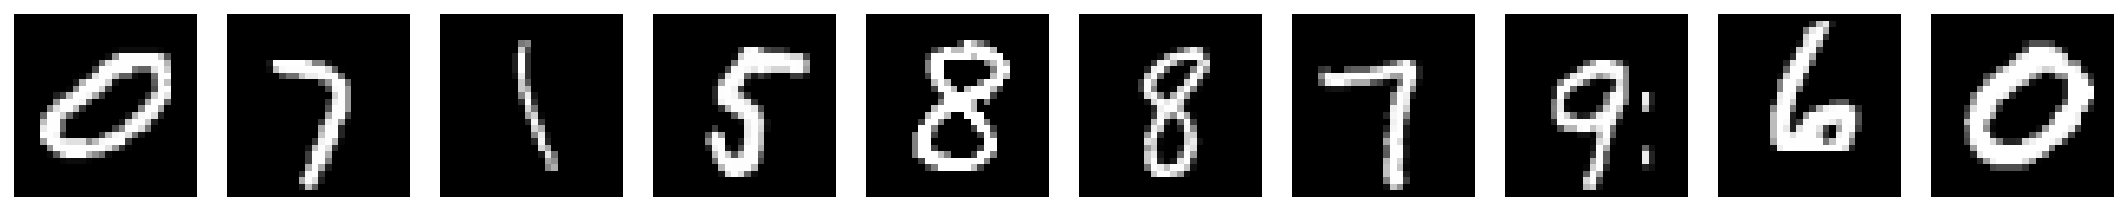

In [7]:
# display random images

plot_row(x_train)

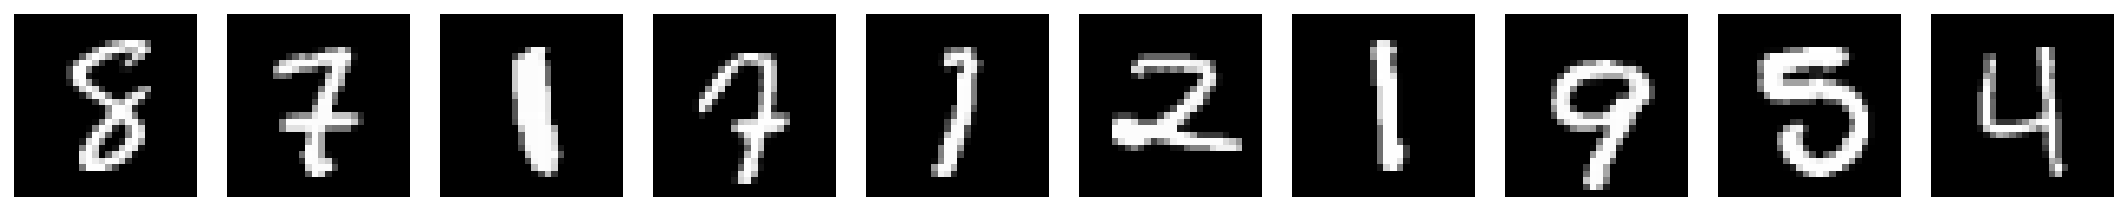

In [8]:
# display the same images, selected randomly in the previous cell

plot_row(x_test[test_selected_idx])

### 1.3 Vectorize samples
The autoencoders in this tutorial are ANNs that require *vectorized* versions of the images (i.e., stretched as a line).

We reshape training and testing images to *vectorized* versions with the method `.reshape` and store them in variable `input_train` and `input_test`, respectively. The variable `input_size` stores the size of the *vectorized* versions of the images.

**Hints**
* Please execute the cells below:

In [9]:
input_size = np.prod(image_shape)

input_train = x_train.reshape([-1, input_size])
input_test = x_test.reshape([-1, input_size])

print('size input_size', input_size)
print('shape input_train', input_train.shape)
print('shape input_train', input_test.shape)

size input_size 784
shape input_train torch.Size([60000, 784])
shape input_train torch.Size([10000, 784])


Please note that the keyword `image_shape` is required to visualize vectorized samples.

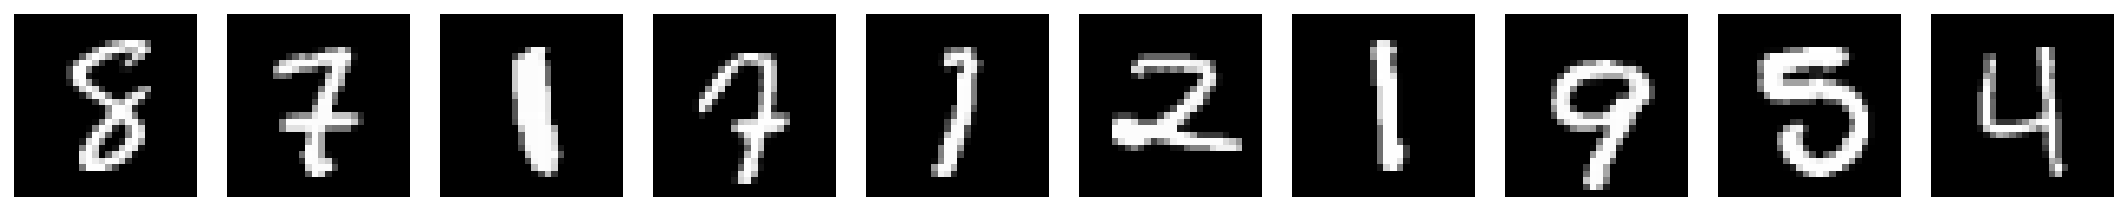

In [10]:
# display the same images, selected randomly in the previous cell

plot_row(input_test[test_selected_idx], image_shape=image_shape)

---
## 2. Latent space visualization
In this section, we introduce tools for visualization of latent space generated by *principal component analysis (PCA)*, and *non-negative matrix factorization (NMF)*.

&nbsp; 

In the tutorial of *W1D5 Dimensionality reduction*, implemented PCA decomposition, and also used the module [sklearn.decomposition](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition) from the package [scikit-learn](https://scikit-learn.org). This module includes several matrix decomposition algorithms that are useful as dimensionality reduction techniques.

Their usage is very straightforward, as shown by this example for truncated SVD:
```
svd = sk.decomposition.TruncatedSVD(n_components=2)

svd.fit(input_train)

svd_latent_train = svd.transform(input_train)
svd_latent_test = svd.transform(input_test)

svd_reconstruction_train = svd.inverse_transform(svd_latent_train)
svd_reconstruction_test = svd.inverse_transform(svd_latent_test)


### 2.1 MNIST with PCA

### Exercise 1: Visualize latent space

The function `plot_latent_generative` produces two plots. The plot on the left maps image samples to coordinates in the latent space. We will call it *latent space plot*.

The plot on the right shows reconstructed images from a grid of locations in latent space - the *reconstruction plot*.

We'll use `sk.decomposition.PCA` (docs [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html)) for PCA decomposition.

**Hints**
* Initialize `sk.decomposition.PCA` in 2 dimensions
* Fit `input_train` with `.fit` method of `sk.decomposition.PCA`
* Obtain latent space representation of `input_test`
* Visualize with `plot_latent_generative`

**Helper function(s)**

In [11]:
help(plot_latent_generative)

Help on function plot_latent_generative in module __main__:

plot_latent_generative(x, y, decoder_fn, image_shape, title=None)
    Two horizontal subplots generated with plot_latent and plot_generative. 
    
    Args:
      x (list, numpy array or torch.Tensor of floats)
          2D coordinates in latent space 
    
      y (list, numpy array or torch.Tensor of floats)
          digit class of each sample
    
      decoder_fn (integer)
          function returning vectorized images from 2D latent space coordinates
    
      image_shape (tuple or list)
          original shape of image
    
      title (string)
          plot title
              
    Returns:
      Nothing.



In [12]:
####################################################
## TODO for students: perform PCA and visualize latent space and reconstruction
  
# pca = 

# pca.fit(input_train)

# pca_latent_test = 

# plot_latent_generative(pca_latent_test, y_test, pca.inverse_transform, image_shape=image_shape)
####################################################

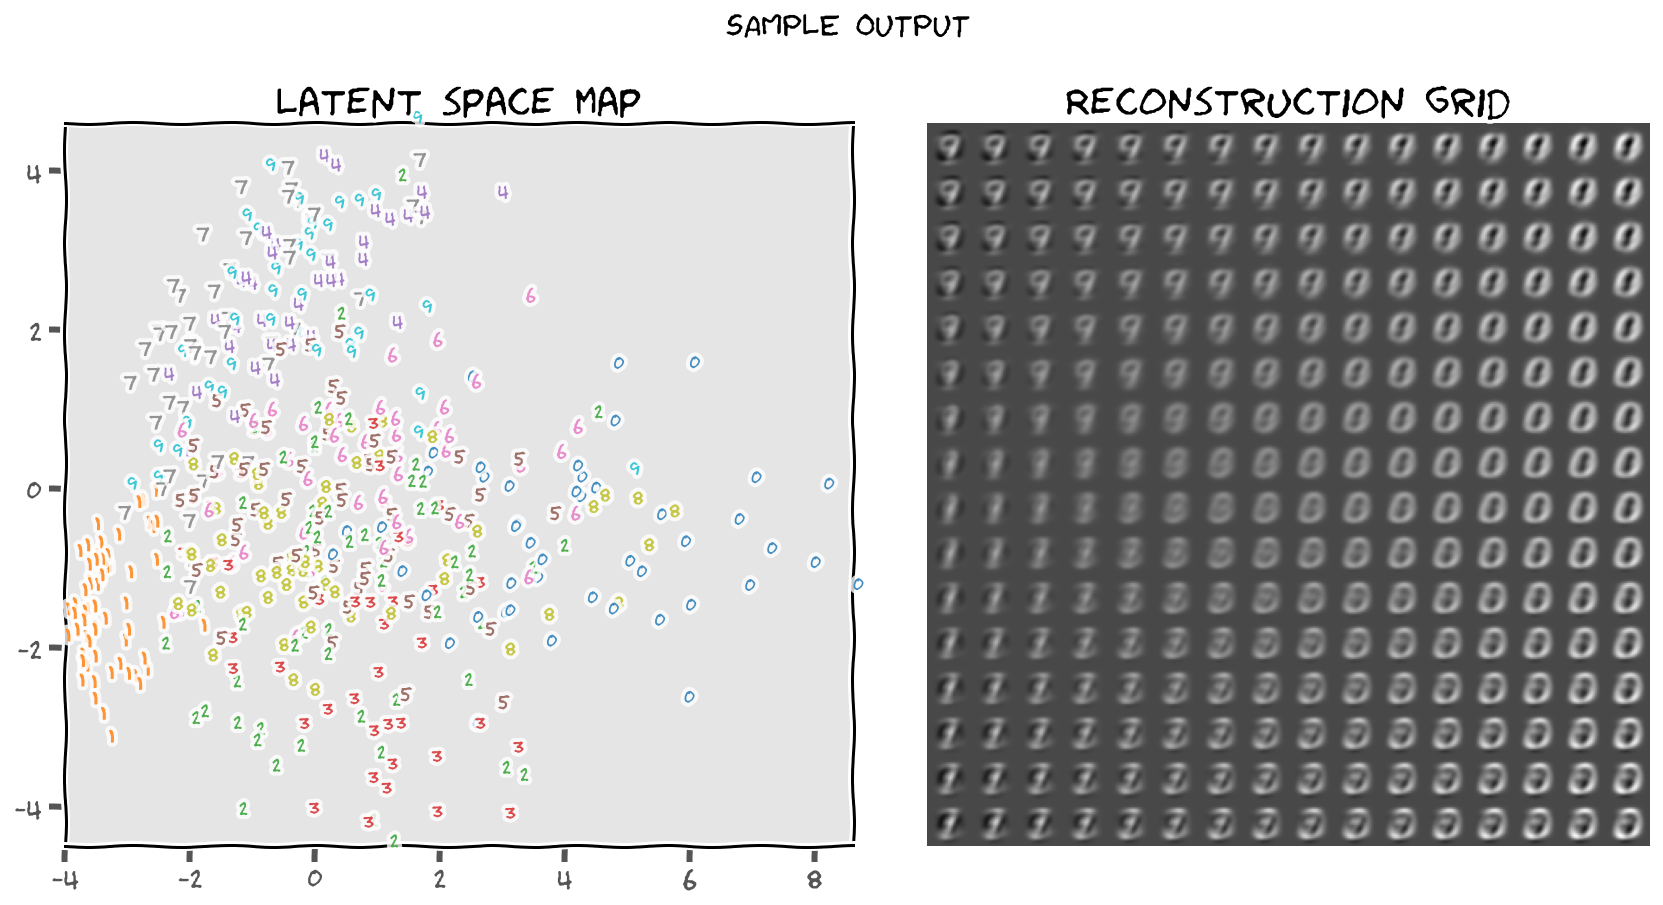

In [13]:
# to_remove solution

pca = sk.decomposition.PCA(n_components=2)

pca.fit(input_train)

pca_latent_test = pca.transform(input_test)

with plt.xkcd():
  plot_latent_generative(pca_latent_test, y_test, pca.inverse_transform, 
                      image_shape=image_shape, title='SAMPLE OUTPUT')

### 2.2 Qualitative analysis PCA
From the latent space plot (on the left), we see that digits `1` and `0` are in opposite regions of the first principal component axis, and similarly, digits `9` and `3` are in opposite regions.

The reconstruction plot (on the right) shows that digits `1`, `0` and `9` are the most recognizable.

Let's inspect the principal components to understand these observations better. The principal components are available as `pca.components_`.

![principal componenets](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/autoencoders/pca-components.png)

Notice that the first principal component encodes digit `0` with positive values (in white) and digit `1` in negative values (in black). The colormap encodes the minimum values in black and maximum values in white, and we know their signs by looking at coordinates in the first principal component axis for digits `0` and `1`.

&nbsp; 

The first principal component axis is, therefore, encoding the "slimness" of the digits.

Similarly, the second principal component encodes digit `9` with positive values (in white) and digit `3` with negative values (in black).

The second principal component axis is encoding, well, something else that is not "slimness" of digits. ;-)

The reconstruction plot also shows that digits `4` and `7` are indistinguishable from digit `9` and similarly for digits `2` and `3`.

**Suggestions**
* Please execute the cell(s) below
* Plot reconstruction samples a few times to get a visual feel of the digit confusions

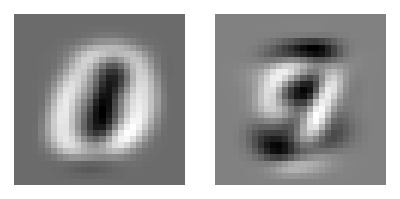

In [14]:
pca_components = pca.components_

plot_row(pca_components, image_shape=image_shape)

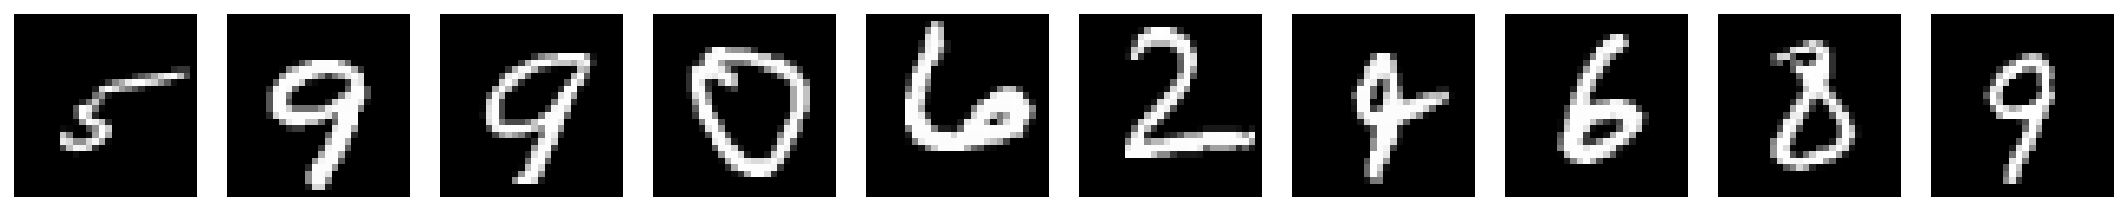

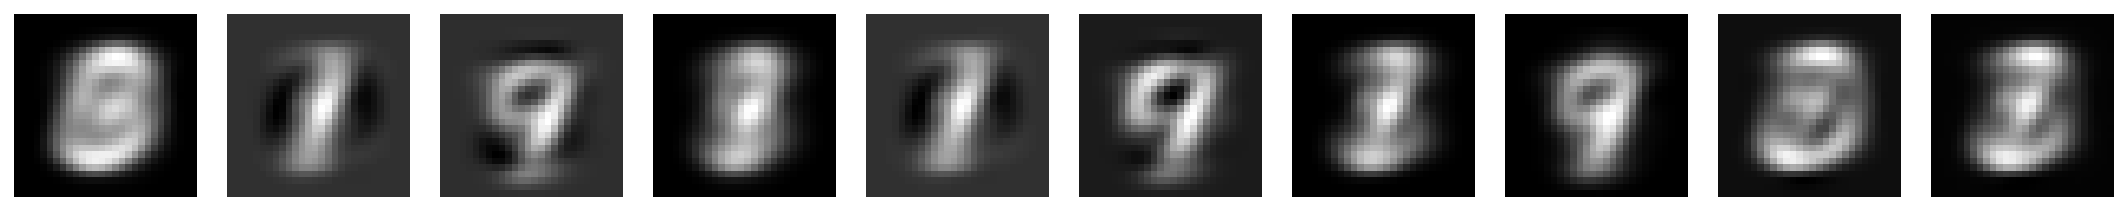

In [15]:
pca_output_test = pca.inverse_transform(pca_latent_test)

plot_row([input_test, pca_output_test], image_shape=image_shape)

### 2.3 Qualitative analysis NMF
We proceed with *non-negative matrix factorization (NMF)* using `sk.decomposition.NMF` (docs [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html)).

A product of positive matrices $W$ and $H$ approximates data matrix $X$, i.e., $X \approx W H$.

The columns of $W$ play the same role as the principal components in PCA.

Digits `0` and `1` are the furthest apart in latent space and better clustered.

Looking at the first component, we see that images gradually resemble digit `0`. A similar progression can be seen for a mixture between digits `1` and `9` in the second component.

That data is shifted by `1` to avoid failure modes near `0` - this is probably related to our scaling choice. Try it without shifting by `1`.

The parameter `init='random'` scales the initial non-negative random matrices and often provides better results - try it as well!

**Suggestions**
* Please execute the cells below

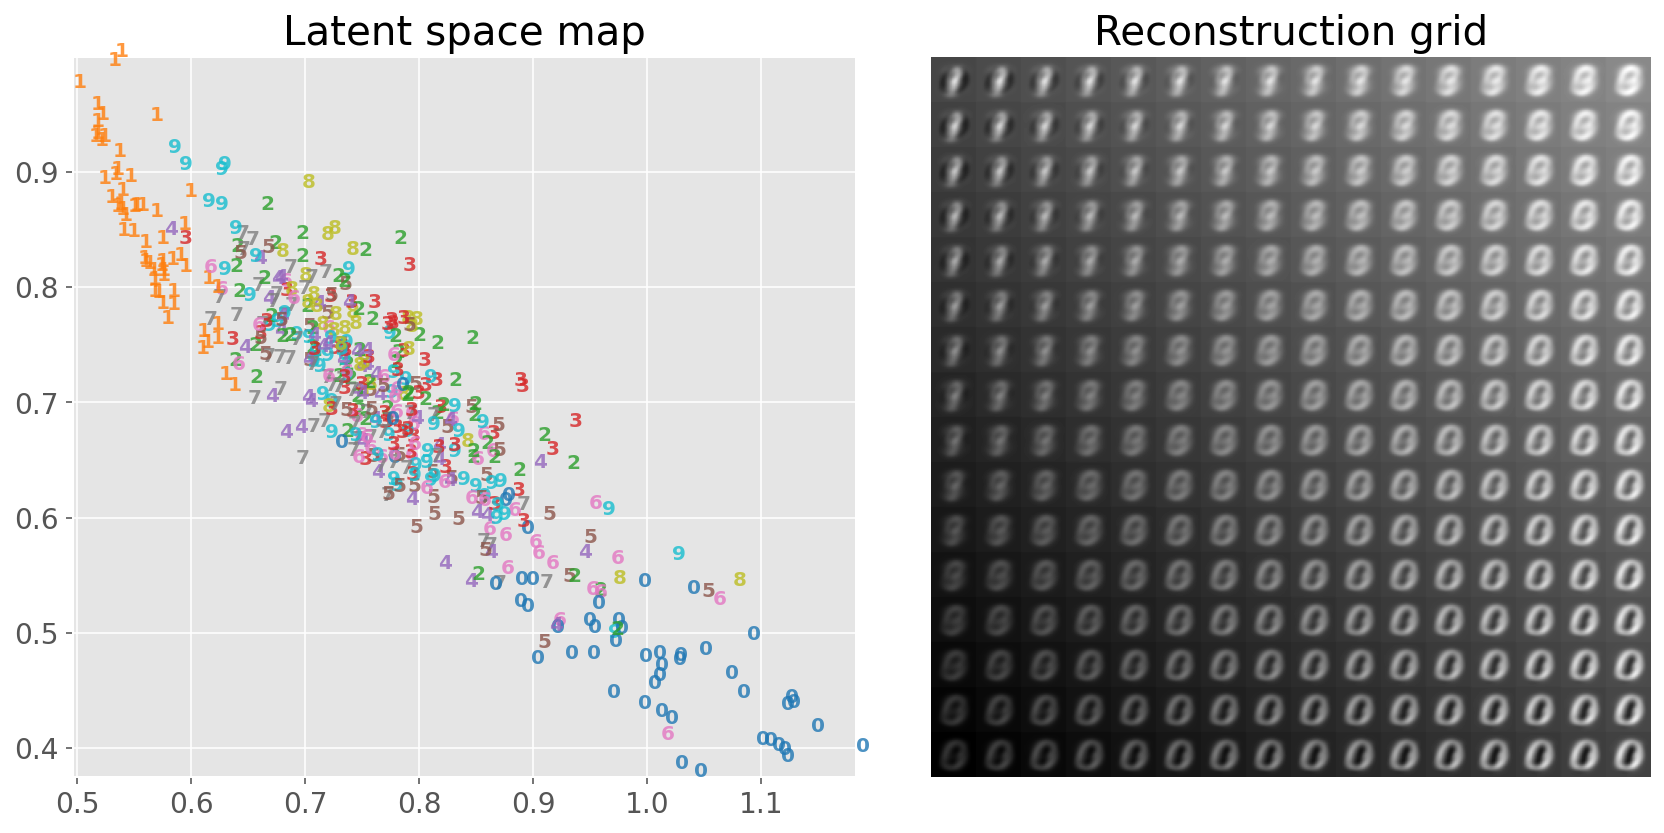

In [16]:
nmf = sk.decomposition.NMF(n_components=2, init='random')

nmf.fit(input_train+1.)

nmf_latent_test = nmf.transform(input_test+1.)


plot_latent_generative(nmf_latent_test, y_test, nmf.inverse_transform, 
                          image_shape=image_shape)

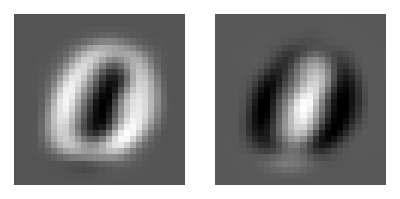

In [17]:
nmf_components = nmf.components_

plot_row(nmf_components, image_shape=image_shape)

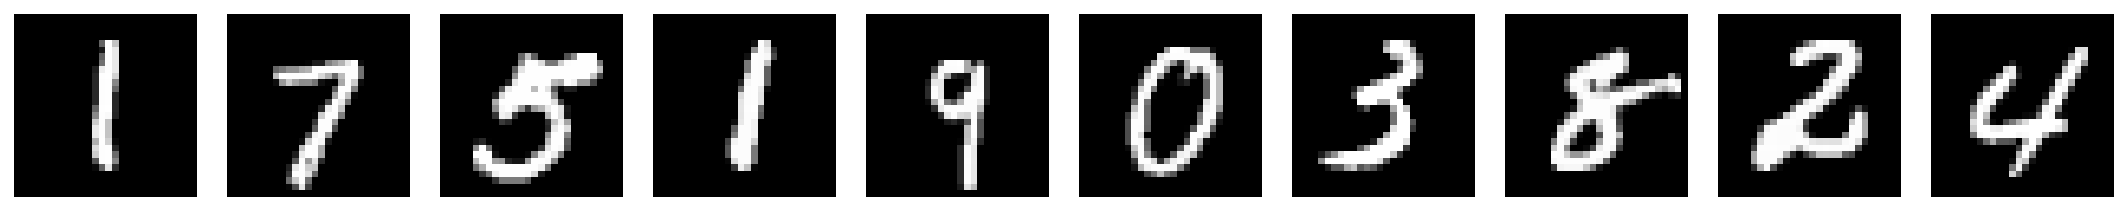

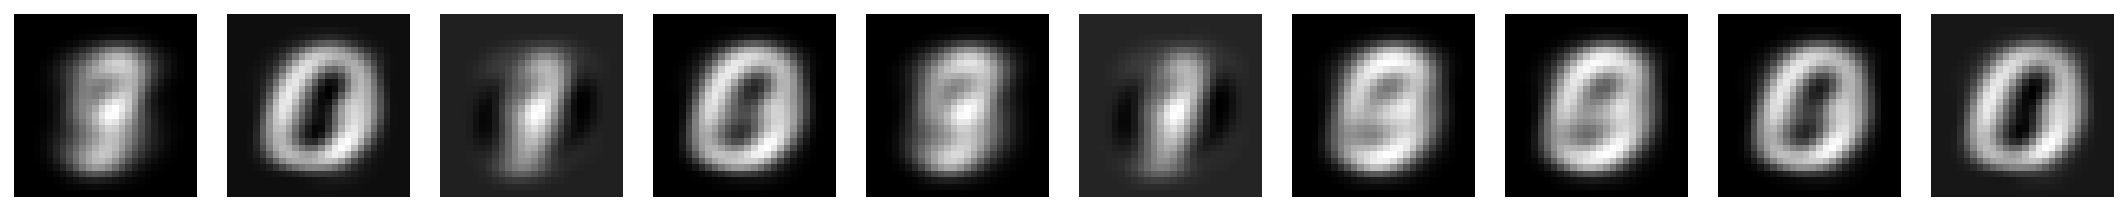

In [18]:
nmf_output_test = nmf.inverse_transform(nmf_latent_test)

plot_row([input_test, nmf_output_test], image_shape=image_shape)

---
## 3. ANN autoencoder
Let's start implementing an ANN autoencoder with a single hidden layer ("shallow") autoencoder.

![Single hidden layer ANN autoencoder](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/autoencoders/ae-ann-1h.png)

The methods for building an ANN presented in W3D4 are better for developing and maturing your research project. Here we present less verbose methods that are perhaps more suitable for an initial exploration phase.

### 3.1 Designing ANN autoencoder (16D)

### Exercise 2: Designing ANN autoencoder
We will use a rectifier [ReLU](https://icml.cc/Conferences/2010/papers/432.pdf) units in the bottleneck layer with `encoding_dim=16` units, and sigmoid units in the output layer. You can read more about activation functions [here](https://en.wikipedia.org/wiki/Activation_function) and rectifiers [here](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)).

![ReLU unit](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/autoencoders/relu.png)

![Single hidden layer ANN autoencoder](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/autoencoders/sigmoid.png)

We already rescaled images to values between `0` and `1` for compatibility with sigmoid units in the output (why?).

**Hints**
* Use `nn.Sequential` to define and initialize an ANN with layer sizes (`input_shape, encoding_dim, input_shape`)
* The linear layers are defined with `nn.Linear` that takes as argument the size of the inputs and outputs
* The PreLU and sigmoid units are defined with `nn.ReLU` and `nn.Sigmoid`, respectively
* Visualize the initial output using `plot_row` with input and output images

In [19]:
encoding_size = 16

model = nn.Sequential(
  nn.Linear(input_size, encoding_size),
  nn.PReLU()
  ######################################################################
  ## TODO for students: add linear and sigmoid layers to desing ANN
  
  # --> insert your code here

  # <--
  ######################################################################
  )

print(model)

Sequential(
  (0): Linear(in_features=784, out_features=16, bias=True)
  (1): PReLU(num_parameters=1)
)


**SAMPLE OUTPUT**

```
Sequential(
  (0): Linear(in_features=784, out_features=16, bias=True)
  (1): PReLU(num_parameters=1)
  (2): Linear(in_features=16, out_features=784, bias=True)
  (3): Sigmoid()
)
```

In [20]:
# to_remove solution

encoding_size = 16

model = nn.Sequential(nn.Linear(input_size, encoding_size),
                      nn.PReLU(),
                      nn.Linear(encoding_size, input_size),
                      nn.Sigmoid())

print(model)

Sequential(
  (0): Linear(in_features=784, out_features=16, bias=True)
  (1): PReLU(num_parameters=1)
  (2): Linear(in_features=16, out_features=784, bias=True)
  (3): Sigmoid()
)


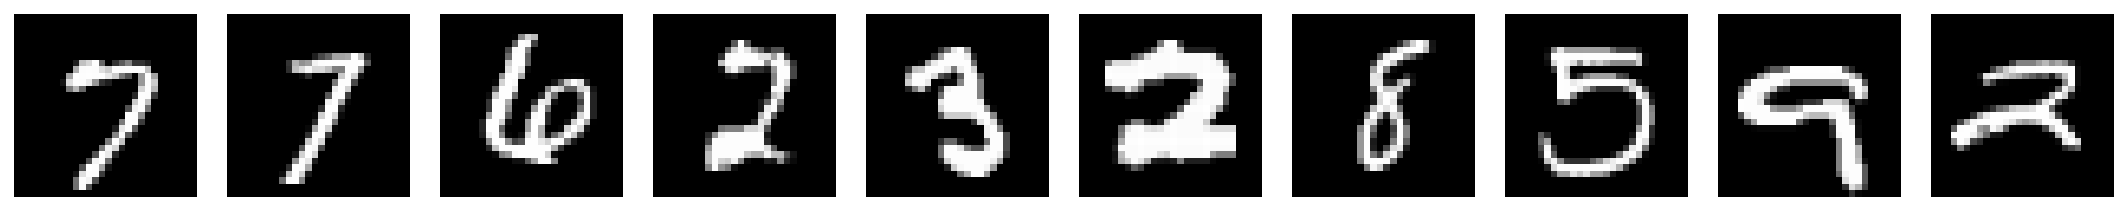

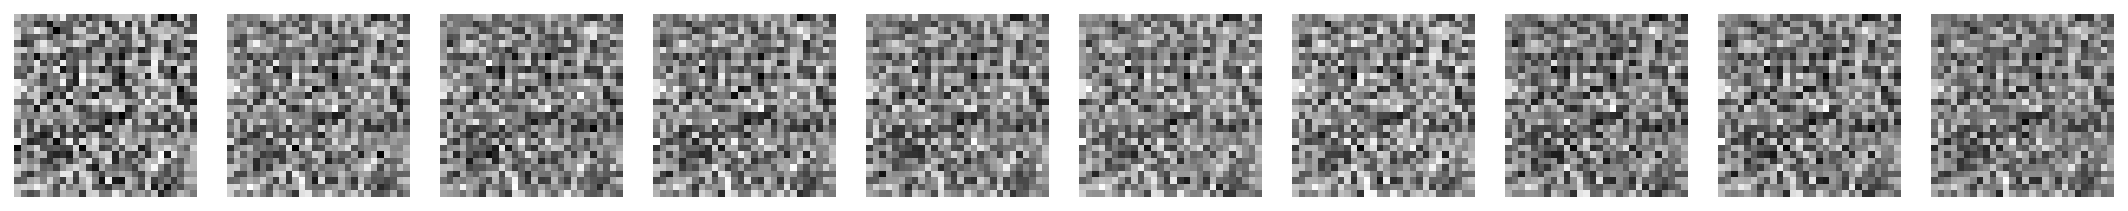

In [21]:
with torch.no_grad():
  output_test = model(input_test)

plot_row([input_test, output_test], image_shape=image_shape)

### 3.2 Training Autoencoder


### Exercise 3: Write the function to train Autoencoder

In this exercise, complete the function to train the network, and test for `3` epochs with Adam optimizer (`optim.Adam`) and choice of mean square error loss (`nn.MSELoss`) and binary cross-entropy `nn.BCELoss()`.

The figures below illustrate these losses, where $\hat{Y}$ is the output value, and $Y$ is the target value.

![mse loss](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/autoencoders/mse.png)

![bce loss](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/autoencoders/bce.png)

**Hints**
* Use the methods of `.zero_grad` and `.step` of `optimizer`, and method `.backward` of `loss`
* Test function `runSGD` by launching several train sessions and watch mse and bce decrease

In [22]:
def minibatch_fn(net, loss_fn, optimizer, batch):
  """
  Trains network for a single batch.

  Args:
    net (torch network)
        ANN network (nn.Module)

    loss_fn (torch loss)
        loss function for SGD

    optimizer (torch optimizer)
        optimizer for SGD

    batch (torch.Tensor)
        vectorized input images
            
  Returns:
    Nothing.
  """

  output_train = net(batch)
  loss = loss_fn(output_train, batch)
  ######################################################################
  ## TODO for students: Calculate the gradients using the loss
  ##                     and update the Autoencoder weights 
  
  # --> insert your code here

  # <--
  ######################################################################
  return(loss)

n_epochs = 3
batch_size = 128

encoding_size = 16

model = nn.Sequential(nn.Linear(input_size, encoding_size),
                      nn.PReLU(),
                      nn.Linear(encoding_size, input_size),
                      nn.Sigmoid())
######################################################################
## TODO for students: Uncomment the two lines below after updating minibatch function
# runSGD(model, input_train, input_test, criterion='mse',
#       n_epochs=n_epochs, batch_size=batch_size, minibatch_fn=minibatch_fn)
######################################################################


Epoch 	 Loss train 	 Loss test
1/3	 0.0351		 0.0347
2/3	 0.0275		 0.0270
3/3	 0.0244		 0.0240

mse	 0.0244		 0.0240
bce	 0.1591		 0.1575


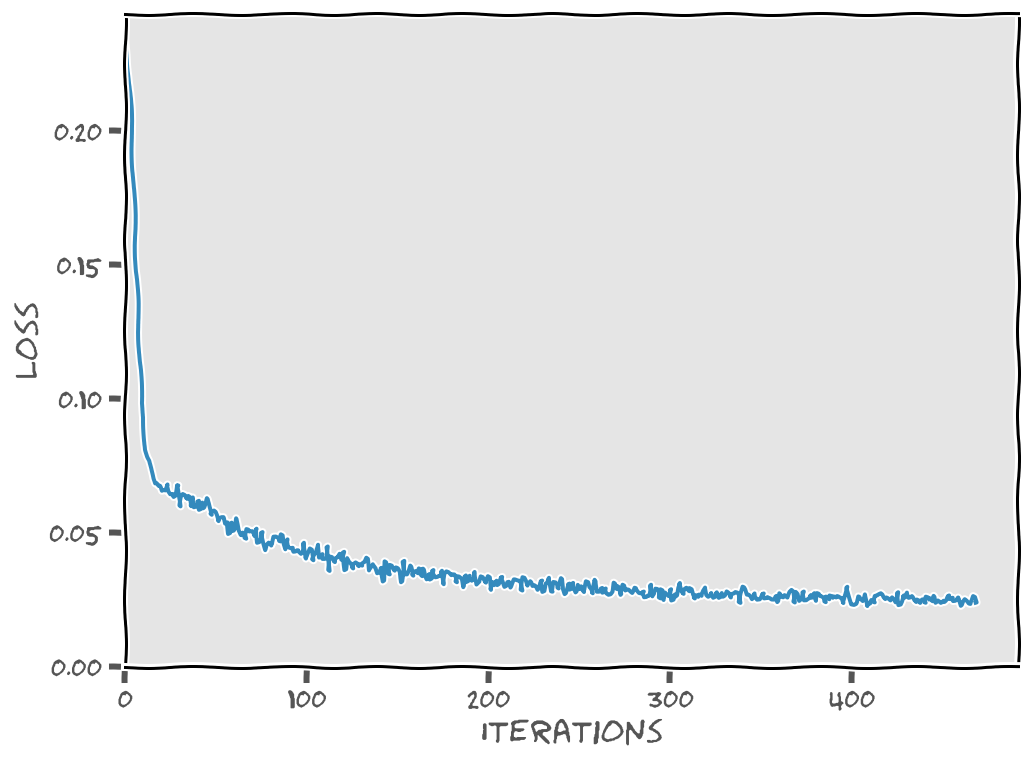

In [23]:
# to_remove solution

def minibatch_fn(net, loss_fn, optimizer, batch):
    """
    Trains network for a single batch.

    Args:
      net (torch network)
          ANN network (nn.Module)

      loss_fn (torch loss)
          loss function for SGD

      optimizer (torch optimizer)
          optimizer for SGD

      batch (torch.Tensor)
          vectorized input images
             
    Returns:
      Nothing.
    """

    output_train = net(batch)
    loss = loss_fn(output_train, batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return(loss)

n_epochs = 3
batch_size = 64

encoding_size = 16

model = nn.Sequential(nn.Linear(input_size, encoding_size),
                      nn.PReLU(),
                      nn.Linear(encoding_size, input_size),
                      nn.Sigmoid())
with plt.xkcd():
  runSGD(model, input_train, input_test, criterion='mse',
        n_epochs=n_epochs, batch_size=batch_size, minibatch_fn=minibatch_fn)

### 3.3 Train autoencoder (16D)
Train the network for `n_epochs=10` epochs and `batch_size=64` with Adam optimizer under mse loss, and visualize a few reconstructed samples.

**Hints**
* Please execute the cells below

In [24]:
encoding_size = 16

model = nn.Sequential(nn.Linear(input_size, encoding_size),
                      nn.ReLU(),
                      nn.Linear(encoding_size, input_size),
                      nn.Sigmoid()
                      )

Epoch 	 Loss train 	 Loss test
1/10	 0.0399		 0.0395
2/10	 0.0317		 0.0313
3/10	 0.0296		 0.0292
4/10	 0.0287		 0.0283
5/10	 0.0284		 0.0279
6/10	 0.0281		 0.0277
7/10	 0.0280		 0.0275
8/10	 0.0278		 0.0273
9/10	 0.0277		 0.0272
10/10	 0.0276		 0.0271

mse	 0.0276		 0.0271
bce	 0.1823		 0.1795


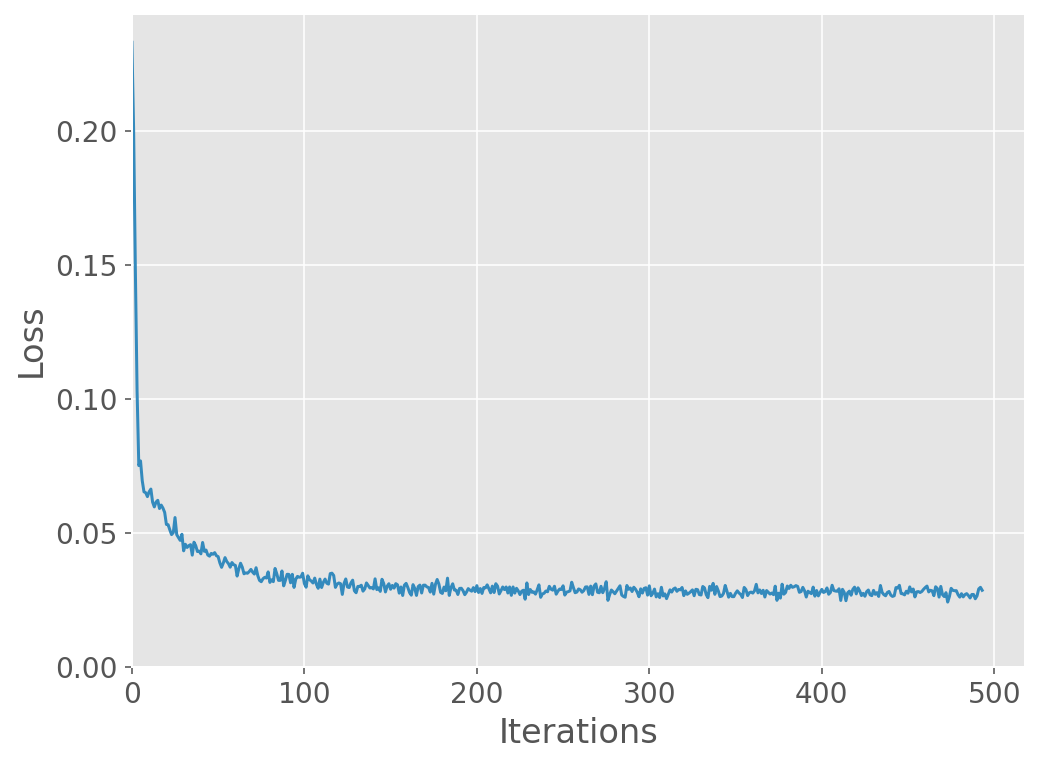

In [25]:
n_epochs = 10
batch_size = 64

runSGD(model, input_train, input_test, criterion='mse', 
      n_epochs=n_epochs, batch_size=batch_size)

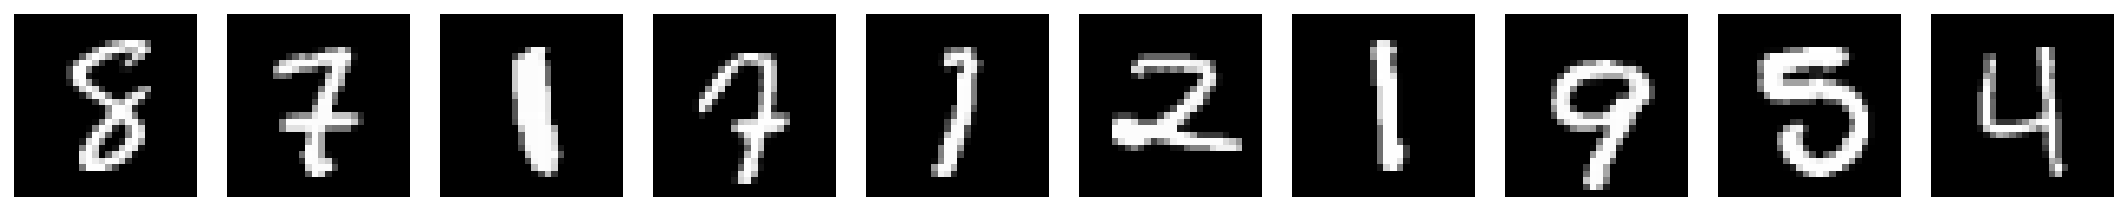

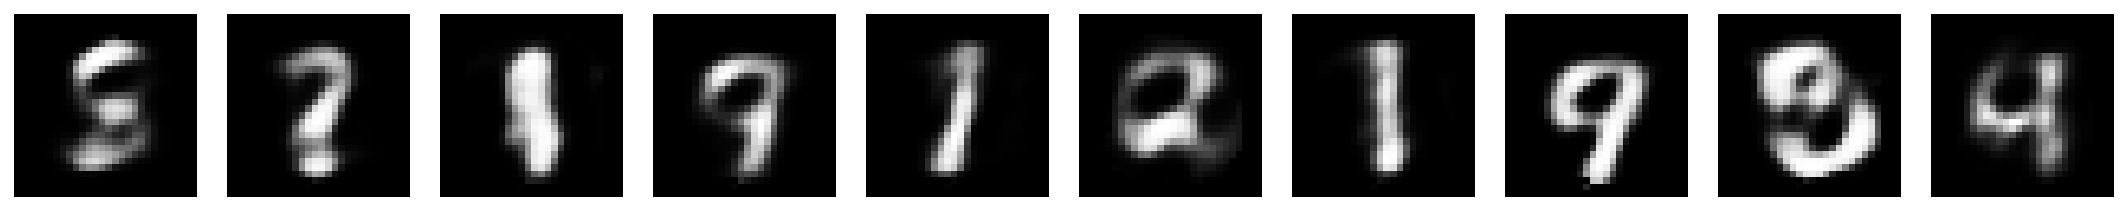

In [26]:
with torch.no_grad():
  output_test = model(input_test)
    
plot_row([input_test[test_selected_idx], output_test[test_selected_idx]], image_shape=image_shape)

### 3.4 Choice of loss function
The loss function determines what the network is optimizing during training, and this translates to the visual aspect of reconstructed images. 

For example, isolated black pixels in the middle of white regions are very unlikely and look noisy. The network can prioritize avoiding such scenarios by maximally penalizing white pixels that turn out black and vice-versa.

The figure below compares mse with bce with a target value $Y=1$, and the output value is ranging from $\hat{Y}\in [0, 1]$. Notice how bce loss dramatically increases for dark pixels $\hat{Y}\simeq 0$.

![bce vs mse loss](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/autoencoders/bce-mse.png)

Let's switch to the binary cross-entropy (bce) loss to verify this. Fortunately, pixel values are compatible with bce loss due to their scaling between 0 and 1.

The visual differences between losses will be subtle since the network is converging well in both cases.

To accentuate differences, we will first retrain under mse loss for `3` epochs, and similarly under bce loss.

Look for isolated pixel areas in mse loss reconstructions.

**Instructions**
* Please execute the cells below

Epoch 	 Loss train 	 Loss test
1/3	 0.0377		 0.0373
2/3	 0.0306		 0.0302
3/3	 0.0270		 0.0266

mse	 0.0270		 0.0266
bce	 0.1676		 0.1661


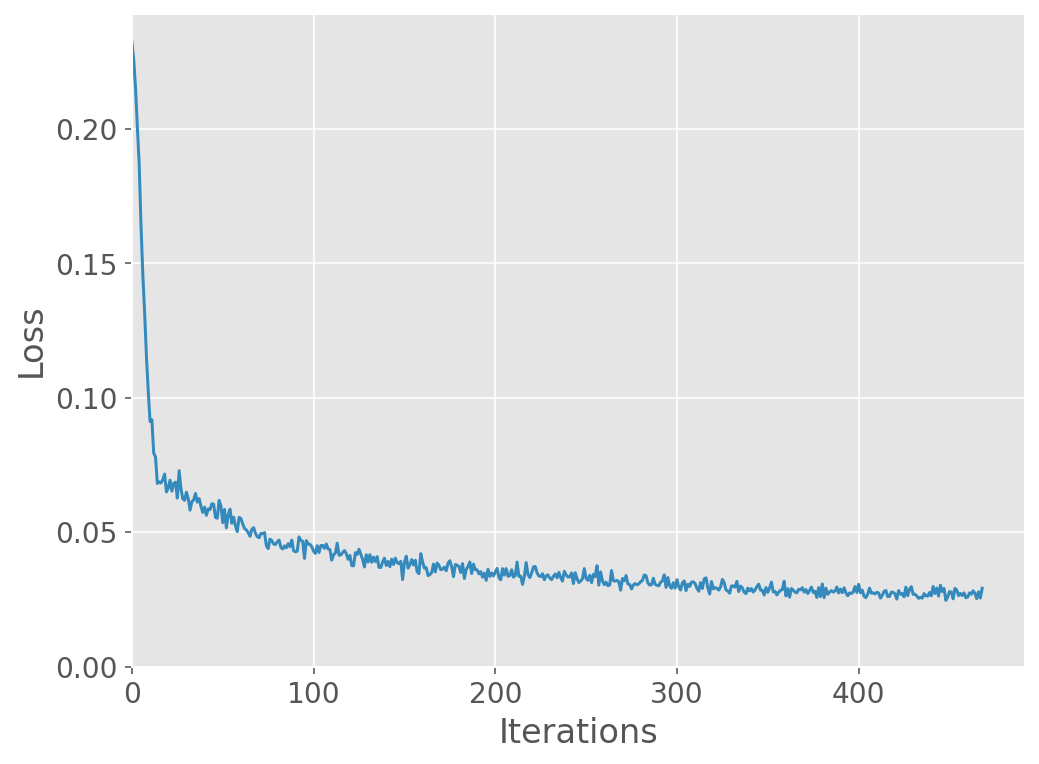

In [27]:
encoding_size = 16
n_epochs = 3
batch_size = 64

model = nn.Sequential(nn.Linear(input_size, encoding_size),
                      nn.ReLU(),
                      nn.Linear(encoding_size, input_size),
                      nn.Sigmoid())

runSGD(model, input_train, input_test, criterion='mse',
      n_epochs=n_epochs, batch_size=batch_size)

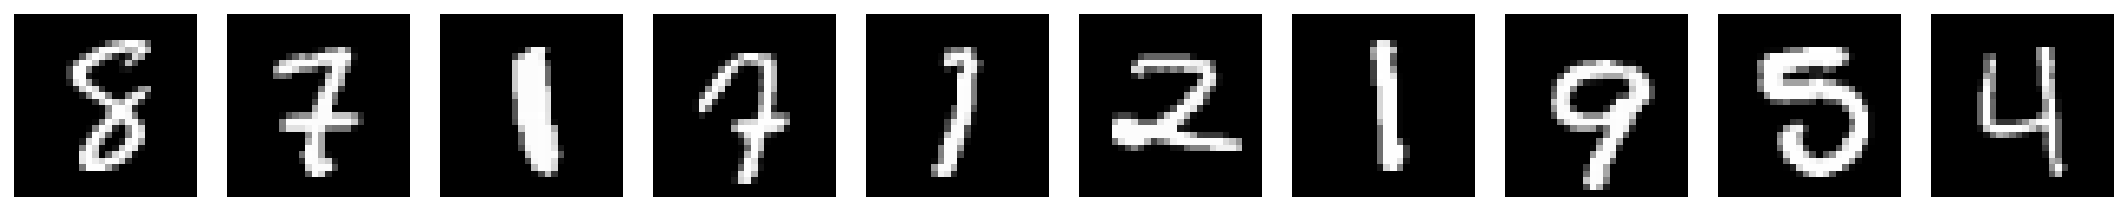

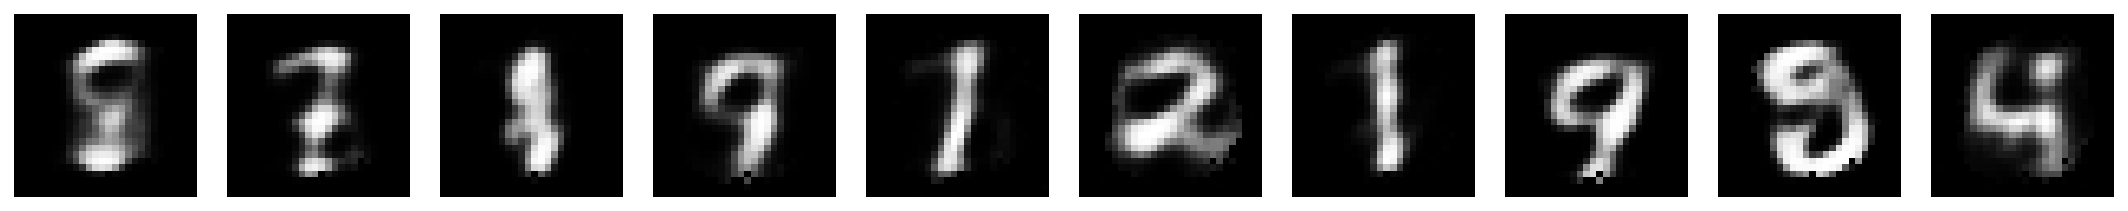

In [28]:
with torch.no_grad():
  output_test = model(input_test)
    
plot_row([input_test[test_selected_idx], output_test[test_selected_idx]], image_shape=image_shape)

Epoch 	 Loss train 	 Loss test
1/3	 0.1813		 0.1800
2/3	 0.1549		 0.1538
3/3	 0.1482		 0.1471

mse	 0.0278		 0.0275
bce	 0.1482		 0.1471


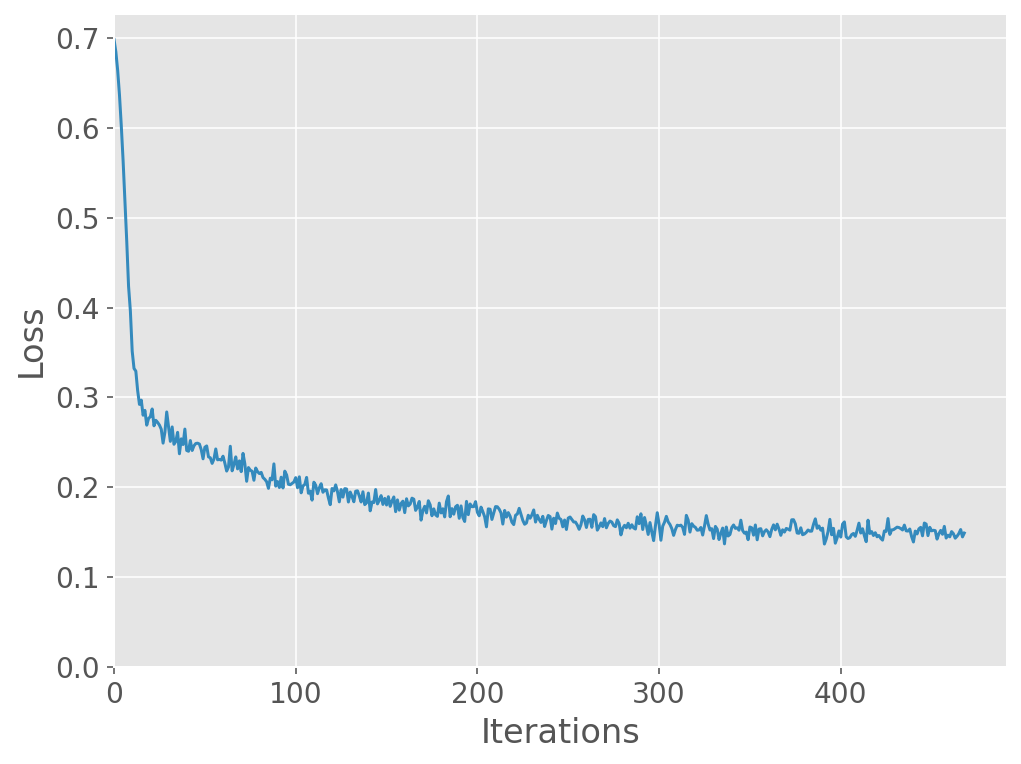

In [29]:
encoding_size = 16
n_epochs = 3
batch_size = 64

model = nn.Sequential(nn.Linear(input_size, encoding_size),
                      nn.ReLU(),
                      nn.Linear(encoding_size, input_size),
                      nn.Sigmoid()
                      )

runSGD(model, input_train, input_test, criterion='bce',
      n_epochs=n_epochs, batch_size=batch_size)

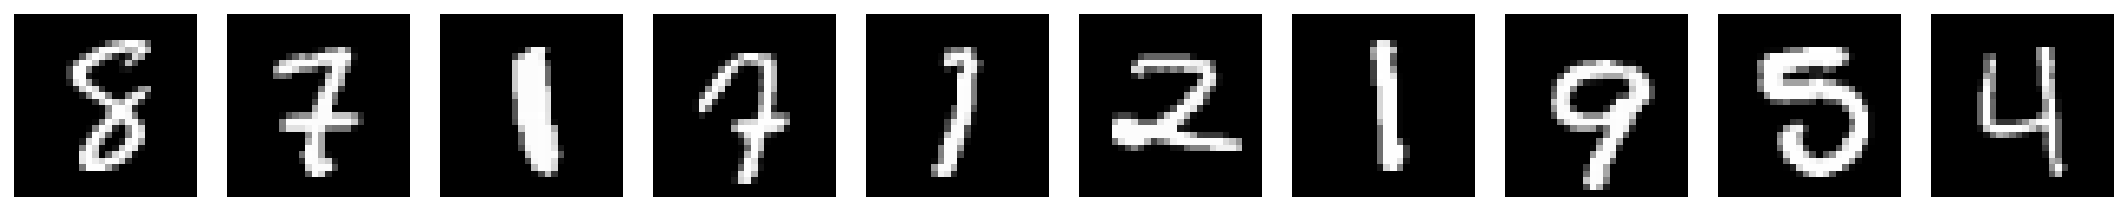

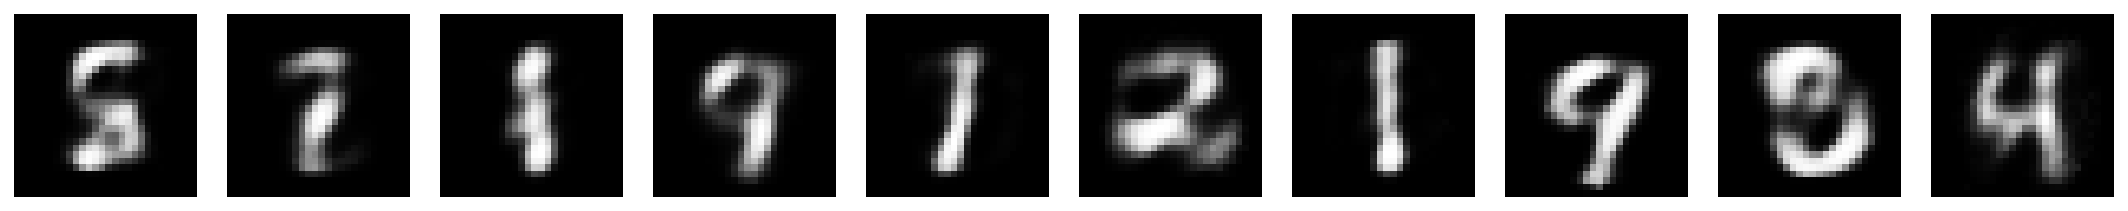

In [30]:
with torch.no_grad():
  output_test = model(input_test)
    
plot_row([input_test[test_selected_idx], output_test[test_selected_idx]], image_shape=image_shape)

### 3.5 Design ANN autoencoder (2D)
We reduce to `encoding_size=2` the number of units in the bottleneck layer to generate a latent space in 2D and compare with those obtained by PCA and NMF in the previous exercises.

To visualize the latent space in 2D, we need to recover coordinates in latent space with an `encoder` network and generate reconstructions from latent space with a `decoder` network. Specifying a sequence of layers from the autoencoder network defines these sub-networks.

```
model = nn.Sequential(...)
encoder = model[:n]
decoder = model[n:]
```

**Instructions**
* Please execute the cells below:

In [31]:
encoding_size = 2

model = nn.Sequential(nn.Linear(input_size, encoding_size),
                      nn.ReLU(),
                      nn.Linear(encoding_size, input_size),
                      nn.Sigmoid())
encoder = model[:2]
decoder = model[2:]

print('Autoencoder', '\n\n', model)

Autoencoder 

 Sequential(
  (0): Linear(in_features=784, out_features=2, bias=True)
  (1): ReLU()
  (2): Linear(in_features=2, out_features=784, bias=True)
  (3): Sigmoid()
)


In [32]:
print('Encoder', '\n\n', encoder)

Encoder 

 Sequential(
  (0): Linear(in_features=784, out_features=2, bias=True)
  (1): ReLU()
)


In [33]:
print('Decoder', '\n\n', decoder)

Decoder 

 Sequential(
  (2): Linear(in_features=2, out_features=784, bias=True)
  (3): Sigmoid()
)


### 3.6 Train the autoencoder (2D)
Train the network for `n_epochs=10` epochs and `batch_size=64`.

The autoencoder often fails to converge with two units in the bottleneck layer. This failure model depends on the initialization of weights and minibatch sequence. To illustrate this, we fix the random number generators (RNGs) as follows:

```
torch.manual_seed(0)
np.random.seed(0)
```
Change `torch.manual_seed` to `1` for an example of successful training.

**Instructions**
* Please execute the cells below

**Hint**
* Change `torch.manual_seed` to `1` for successful training

Epoch 	 Loss train 	 Loss test
1/10	 0.2650		 0.2650
2/10	 0.2596		 0.2598
3/10	 0.2570		 0.2571
4/10	 0.2551		 0.2552
5/10	 0.2536		 0.2538
6/10	 0.2521		 0.2523
7/10	 0.2506		 0.2508
8/10	 0.2490		 0.2491
9/10	 0.2473		 0.2473
10/10	 0.2458		 0.2457

mse	 0.0617		 0.0619
bce	 0.2458		 0.2457


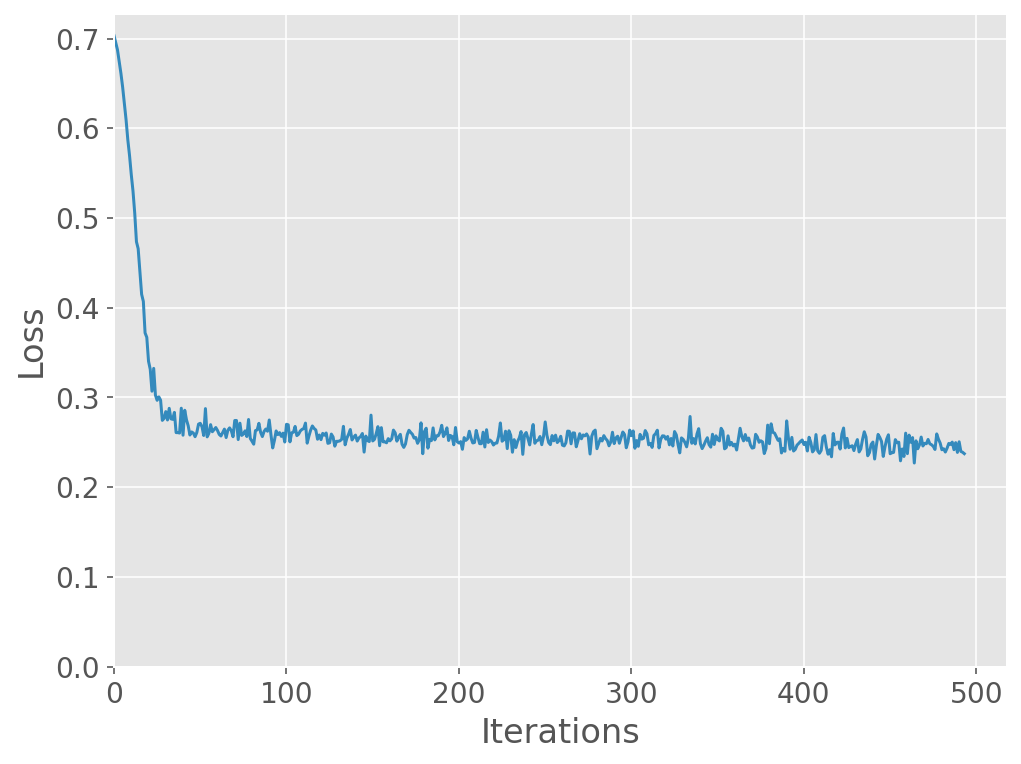

In [34]:
torch.manual_seed(0)
np.random.seed(0)

encoding_size = 2
n_epochs = 10
batch_size = 64

model = nn.Sequential(nn.Linear(input_size, encoding_size),
                      nn.ReLU(),
                      nn.Linear(encoding_size, input_size),
                      nn.Sigmoid())
encoder = model[:2]
decoder = model[2:]

runSGD(model, input_train, input_test, criterion='bce', 
       n_epochs=n_epochs, batch_size=batch_size)

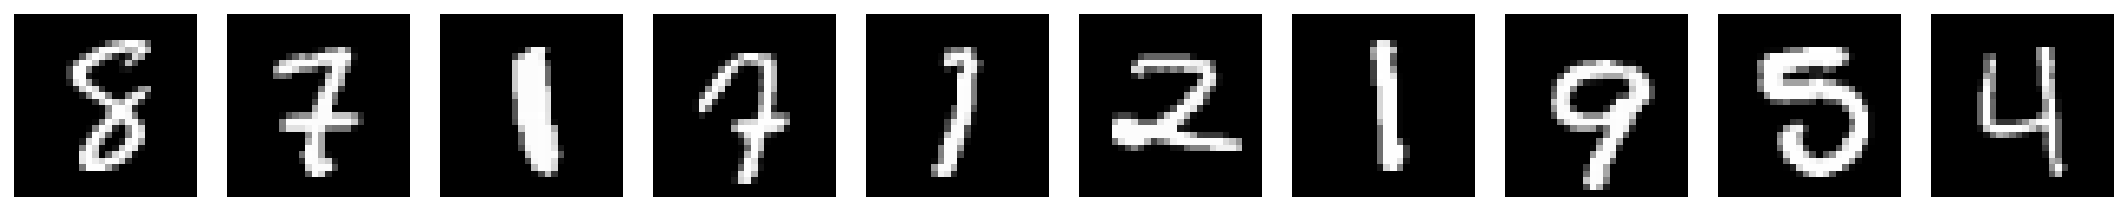

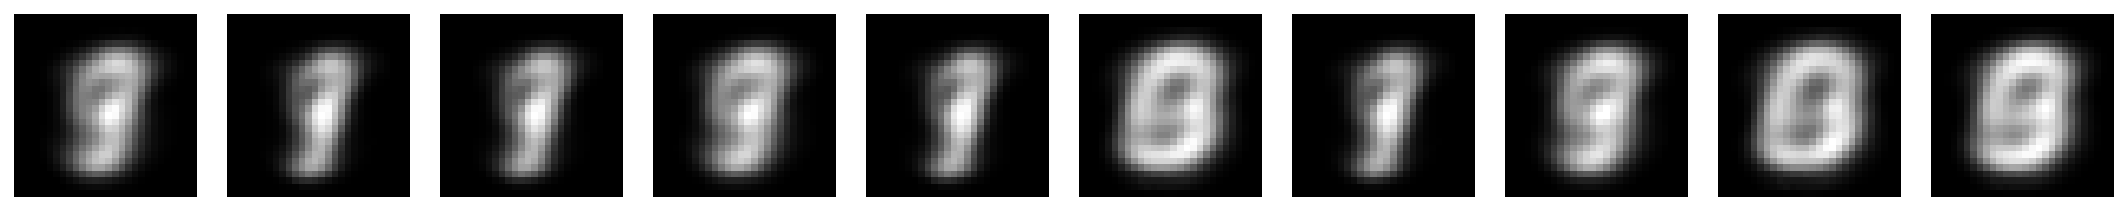

In [35]:
with torch.no_grad():
  output_test = model(input_test)

plot_row([input_test[test_selected_idx], output_test[test_selected_idx]], image_shape=image_shape)

with torch.no_grad():
  latent_test = encoder(input_test)
  
plot_latent_generative(latent_test, y_test, decoder, 
                      image_shape=image_shape)

### 3.7 Choice of activation function
We will use [PReLU](https://arxiv.org/abs/1502.01852) units in the bottleneck layer, which adds a parameter and enables negative activations. This change affords a little bit more of wiggle room for the autoencoder to model data compared to ReLU units.

![PreLU unit](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/autoencoders/prelu.png)


**Suggestions**
* Please execute the cells below

Epoch 	 Loss train 	 Loss test
1/10	 0.2623		 0.2625
2/10	 0.2554		 0.2554
3/10	 0.2491		 0.2487
4/10	 0.2433		 0.2429
5/10	 0.2385		 0.2379
6/10	 0.2347		 0.2340
7/10	 0.2319		 0.2312
8/10	 0.2302		 0.2292
9/10	 0.2290		 0.2281
10/10	 0.2282		 0.2271

mse	 0.0561		 0.0558
bce	 0.2282		 0.2271


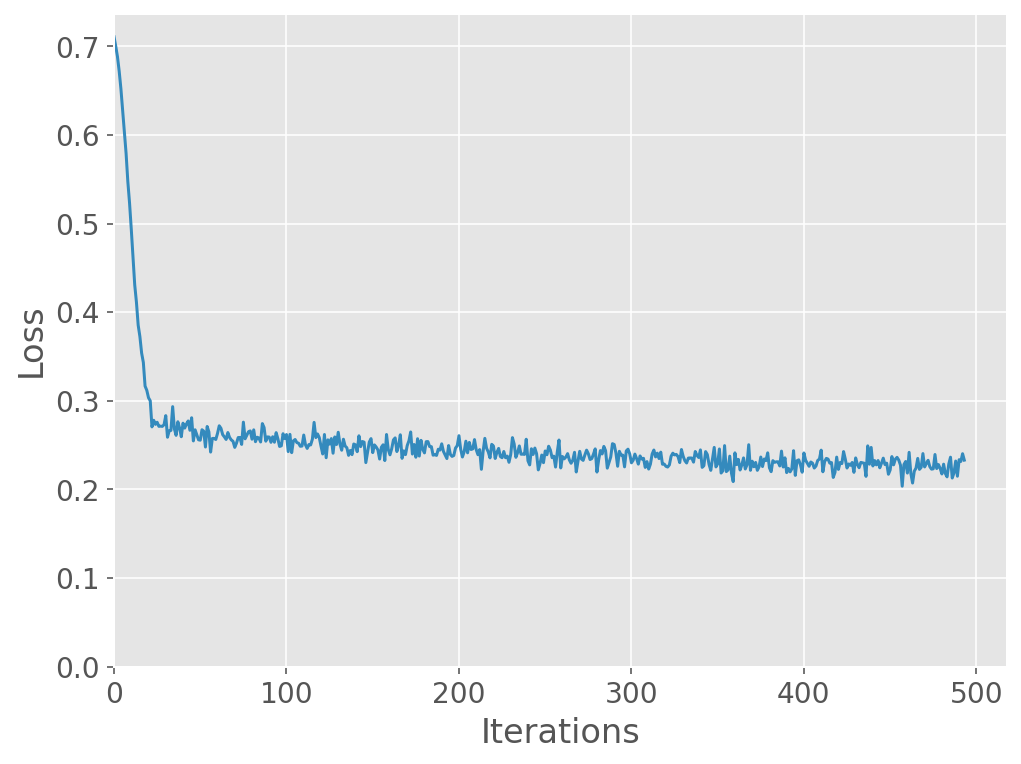

In [36]:
encoding_size = 2

model = nn.Sequential(nn.Linear(input_size, encoding_size),
                      nn.PReLU(),
                      nn.Linear(encoding_size, input_size),
                      nn.Sigmoid())

encoder = model[:2]
decoder = model[2:]

n_epochs = 10
batch_size = 64

runSGD(model, input_train, input_test, criterion='bce', 
       n_epochs=n_epochs, batch_size=batch_size)

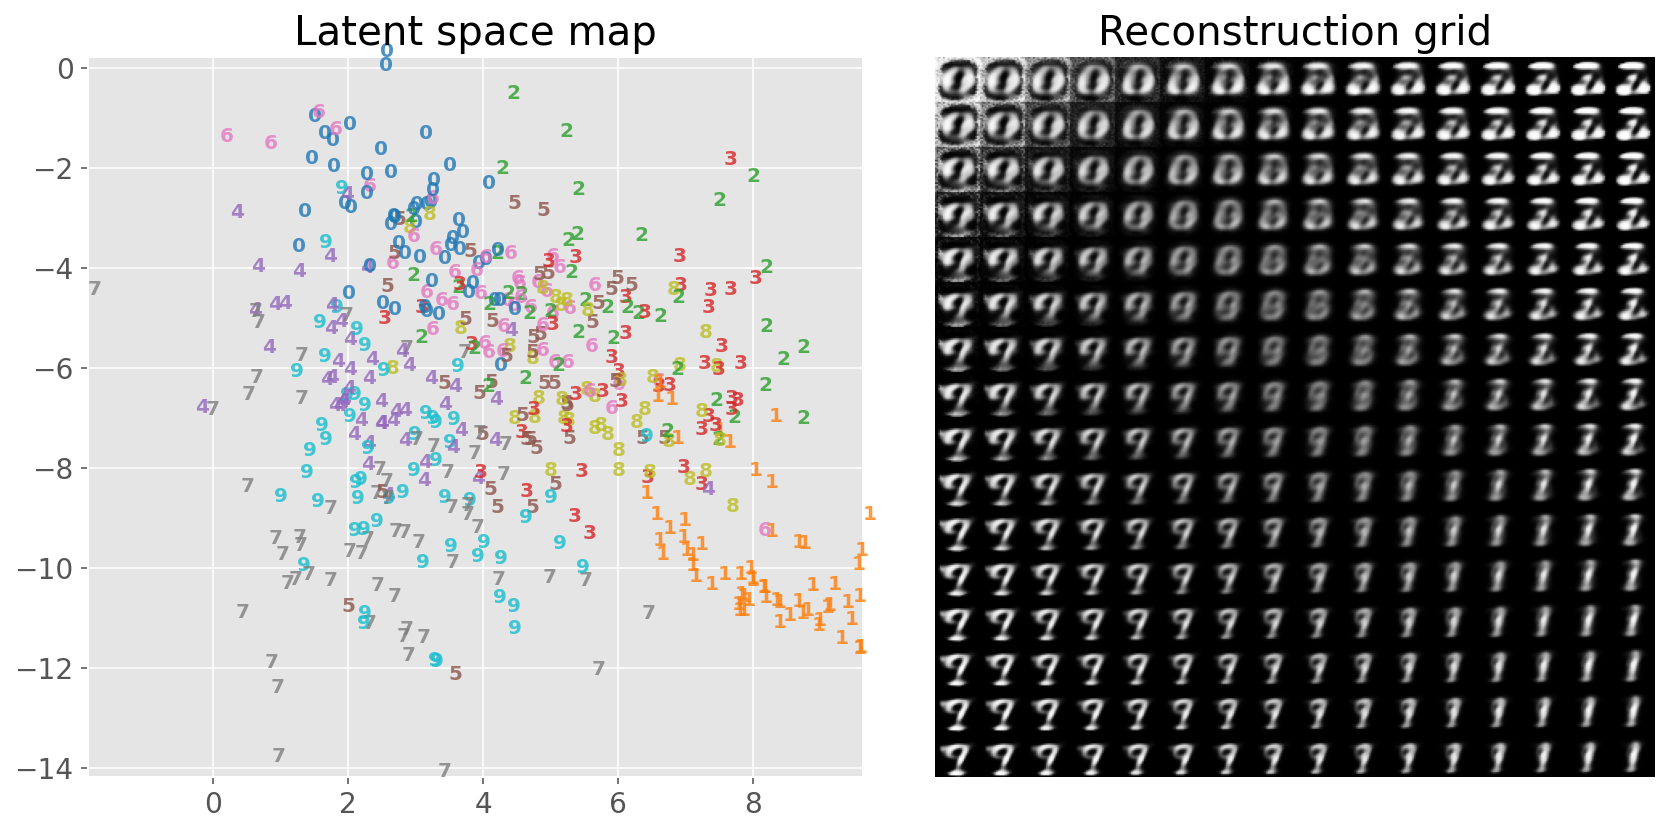

In [37]:
with torch.no_grad():
  latent_test = encoder(input_test)

plot_latent_generative(latent_test, y_test, decoder, 
                      image_shape=image_shape)

### 3.8 Expressive power in 2D
The ANN autoencoder we used in this tutorial has a latent space representation that is comparable to PCA. This behavior is unsurprising since training the network with linear (identity) activation functions under mse loss is [very similar to performing PCA](https://arxiv.org/abs/1804.10253).

To check this, we plot both latent spaces side-by-side, look for classes of digits that cluster successfully, and those still mixing with others. In this aspect, both representations are very similar.

**Suggestions**
* Please execute the cells below:

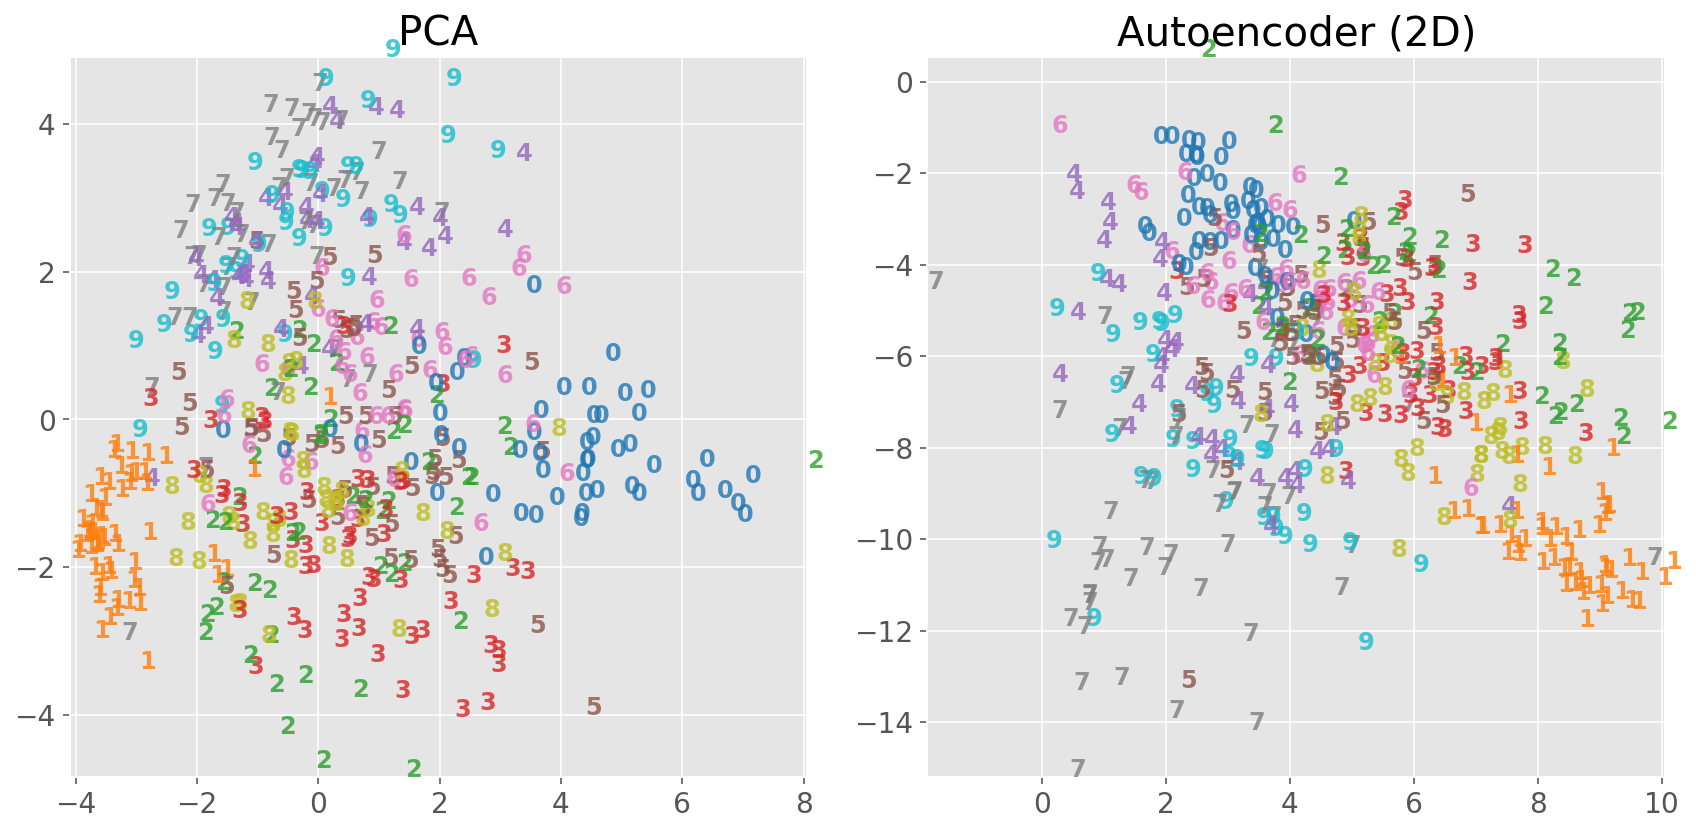

In [38]:
plot_latent_ab(pca_latent_test, latent_test, y_test,
               title_a='PCA', title_b='Autoencoder (2D)')

---
## Summary
In this notebook, we got comfortable with basic techniques to create low-dimensional representations, visualize them, and build shallow autoencoders with latent spaces of different dimensions.

**In conclusion, we saw that the expressive power of PCA and shallow autoencoder in 2D latent space is very similar.**

In the next notebook, we will see ways to improve the autoencoder architecture that cluster MNIST correctly.